In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

import re
import emoji

In [2]:
train = pd.read_csv('data/train.tsv', sep='\t')
train.head(3)

,id,name,coordinates,category,address,target,traffic_300m,homes_300m,works_300m,female_300m,...,doramas_1000m,computer_components_1000m,humor_1000m,car_market_1000m,no_higher_education_1000m,goods_for_moms_and_babies_1000m,age_25-34_1000m,male_1000m,phone_repair_1000m,mean_income_1000m
0,1365,"Городская поликлиника № 109, филиал № 2","[37.735049, 55.719667]",health,"Грайвороновская ул., 18, корп. 1, Москва",4.1,75429,16113.582471,15756.246444,51316.0,...,4668.0,7718.0,33389.0,18306.0,426241.0,415.0,380148.0,619550.0,2781.0,113767.387249
1,8230,Wellness Club Nebo,"[37.537083, 55.749511]",swimming_pool,"Пресненская наб., 12, Москва",3.6,246535,8578.458740,31315.672794,192547.0,...,3431.0,11463.0,61107.0,23662.0,488685.0,356.0,436721.0,764733.0,4264.0,122931.921255
2,29071,Первый МГМУ имени Сеченова,"[37.576087, 55.73734]",higher_education_institutions,"ул. Плющиха, 57, стр. 1, Москва",3.5,83490,12650.492399,12490.096776,56045.0,...,4674.0,14899.0,78547.0,31585.0,866939.0,520.0,712973.0,1143924.0,6518.0,117643.549941


In [3]:
reviews = pd.read_csv('data/reviews.tsv', sep='\t')
reviews.head()

,id,text
0,43591,"Мармелад в целом неплохой, но цены завышены, м..."
1,43591,"Не нравится, что товар выложен открыто, слишко..."
2,43591,"Часто попадается сухой мармелад, дубовый впере..."
3,43591,"Персонал был одет в костюмы пиратов, а ассорти..."
4,43591,"Вкусный мармелад с широким ассортиментом форм,..."


In [4]:
cols_300m = train.columns[train.columns.str.endswith('300m')]
cols_1000m = train.columns[train.columns.str.endswith('1000m')]

In [5]:
num_of_reviews = pd.DataFrame(reviews['id'].value_counts()).reset_index()
num_of_reviews.columns = ['id', 'num_of_reviews']

In [6]:
reviews = reviews.groupby('id')['text'].apply(lambda x: ' '.join(x)).reset_index()
reviews = reviews.rename(columns={'text': 'reviews'}, errors='raise')

In [7]:
# embeds = pd.read_parquet('embeddings3.parquet')
# embeds.head(3)

In [8]:
# from sklearn.preprocessing import StandardScaler
# embeds.iloc[:, 1:] = StandardScaler().fit_transform(embeds.iloc[:, 1:])

In [9]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
punct_pattern = re.compile(r'[^\w\s]')

def text_basic_features(text):
    if not isinstance(text, str) or len(text) == 0:
        return pd.Series({
            'text_len': 0,
            'upper_share': 0,
            'punct_share': 0,
            'emoji_share': 0,
            'url_share': 0
        })
    length = len(text)
    upper = sum(1 for c in text if c.isupper()) / length
    punct = len(punct_pattern.findall(text)) / length
    emoj = len([ch for ch in text if ch in emoji.EMOJI_DATA]) / length
    url = len(url_pattern.findall(text)) / length
    return pd.Series({
        'text_len': length,
        'upper_share': upper,
        'punct_share': punct,
        'emoji_share': emoj,
        'url_share': url
    })

In [10]:
def prep(df):
    # --- Координаты ---
    df['lon'] = df['coordinates'].apply(lambda x: eval(x)[0])
    df['lat'] = df['coordinates'].apply(lambda x: eval(x)[1])

    # --- Отзывы ---
    df = df.merge(reviews, on='id', how='left')
    df['reviews_empty'] = df['reviews'].isna()
    df['reviews'] = df['reviews'].fillna('EMPTY')
    df = df.merge(num_of_reviews, on='id', how='left')
    df['num_of_reviews'] = df['num_of_reviews'].fillna(0)

    # --- Базовые фичи текста ---
    text_feats = df['reviews'].apply(text_basic_features)
    df = pd.concat([df, text_feats], axis=1)

    # --- Адрес ---
    df['address'] = df['address'].fillna('other')

    # === Фичи из name ===
    df['name'] = df['name'].fillna('').str.lower()
    
    df['name_len'] = df['name'].str.len()
    df['name_upper_ratio'] = df['name'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )

    # === Признаки по окружению (_300m / _1000m) ===
    def safe_div(a, b):
        return a / b if b and b != 0 else 0

    if {'traffic_300m', 'homes_300m'}.issubset(df.columns):
        df['traffic_per_home_300m'] = df.apply(lambda r: safe_div(r['traffic_300m'], r['homes_300m']), axis=1)
    if {'works_1000m', 'homes_1000m'}.issubset(df.columns):
        df['works_per_home_1000m'] = df.apply(lambda r: safe_div(r['works_1000m'], r['homes_1000m']), axis=1)

    for base in ['traffic', 'homes', 'works', 'mean_income']:
        c300, c1000 = f'{base}_300m', f'{base}_1000m'
        if c300 in df.columns and c1000 in df.columns:
            df[f'{base}_growth'] = df.apply(lambda r: safe_div(r[c1000], r[c300]), axis=1)

    # === Агрегация интересов ===
    interest_groups = {
        'beauty_interest': ['beauty_salons', 'laser_hair_removal', 'manicure', 'pharmacy', 'clinics'],
        'auto_interest': ['premium_class_cars', 'mid_class_cars', 'car_services', 'car_parts'],
        'entertainment_interest': ['bars', 'restaurants_cafes', 'movies_and_series', 'sports', 'culture'],
        'tech_interest': ['mobile_phones', 'laptops_tablets_computers', 'computer_games'],
        'family_interest': ['childrens_goods', 'baby_food', 'toys_and_games', 'pregnancy_websites'],
        'food_interest': ['food_delivery', 'pizza_delivery', 'sushi_delivery', 'cooking'],
        'finance_interest': ['banking_services', 'insurance', 'deposits', 'lending', 'mortgage'],
    }
    for new_col, cols in interest_groups.items():
        existing = [c for c in cols if c in df.columns]
        if existing:
            df[new_col] = df[existing].mean(axis=1)

    return df


In [11]:
train = prep(train)

In [12]:
emb_df = pd.read_parquet('emb_df.parquet')
sent_df = pd.read_parquet('sentiments.parquet')

train = train.merge(emb_df, on='id', how='left')
train = train.merge(sent_df, on='id', how='left')

In [13]:
train = train[train['target'] != 0]

In [14]:
from sklearn.cluster import KMeans

In [15]:
kmeans = KMeans(n_clusters=9, random_state=185, n_init="auto").fit(train[['lat', 'lon']])
train['geo_cluster'] = kmeans.labels_

In [16]:
train['geo_sentiment_mean'] = train.groupby('geo_cluster')['sent_score'].transform('mean')
train['geo_sentiment_diff'] = train['sent_score'] - train['geo_sentiment_mean']

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # Берём только координаты
# X = train[['lat', 'lon']].values

# # Список k для проверки
# k_values = range(1, 21)
# inertias = []

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X)
#     inertias.append(kmeans.inertia_)

# # График метода локтя
# plt.figure(figsize=(8,5))
# plt.plot(k_values, inertias, marker='o')
# plt.xlabel('Количество кластеров (k)')
# plt.ylabel('Inertia (сумма квадратов расстояний)')
# plt.title('Метод локтя для выбора числа кластеров')
# plt.xticks(k_values)
# plt.grid(True)
# plt.show()


In [ ]:
# import folium

# map_center = [train['lat'].mean(), train['lon'].mean()]
# m = folium.Map(location=map_center, zoom_start=12)


# colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'pink', 'lightgreen', 'darkblue']

# # Добавляем точки
# from tqdm import tqdm
# for idx, row in tqdm(train.iterrows(), total=len(train)):
#     folium.CircleMarker(
#         location=[row['lat'], row['lon']],
#         radius=4,
#         color=colors[row['geo_cluster'] % len(colors)],
#         fill=True,
#         fill_color=colors[row['geo_cluster'] % len(colors)],
#         fill_opacity=0.7,
#         popup=f"ID: {row['id']}, Cluster: {row['geo_cluster']}"
#     ).add_to(m)

# # Показываем карту
# m.save('clusters_map.html')

# catboost

In [17]:
cols_to_drop = ['target', 'coordinates', 'id']
cat_cols = ['category', 'reviews_empty', 'geo_cluster']
text_cols = ['reviews', 'name', 'address']

In [18]:
y = train['target']
X = train.drop(columns=cols_to_drop)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from scipy.sparse import hstack, csr_matrix

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import numpy as np
import warnings
from nltk.corpus import stopwords 

In [21]:
warnings.filterwarnings("ignore")

# --- Настройки колонок ---
cols_to_drop = ['target', 'coordinates', 'id']
cat_cols = ['category', 'reviews_empty', 'geo_cluster']
text_cols = ['reviews', 'name', 'address']

y = train['target']
X = train.drop(columns=cols_to_drop)

In [22]:
for col in text_cols:
    X[col] = X[col].fillna('')

# --- TF-IDF векторизация ---
tfidf_vectorizers = {}
tfidf_features = []

In [23]:
for col in text_cols:
    vec = TfidfVectorizer(
        max_features=1000,  # ограничим размер словаря, чтобы не взорваться по памяти
        stop_words=stopwords.words('russian')
    )
    tfidf_matrix = vec.fit_transform(X[col])
    tfidf_vectorizers[col] = vec
    tfidf_features.append(tfidf_matrix)

In [24]:
X_tfidf = hstack(tfidf_features).tocsr()

# --- OHE и числовые признаки ---
num_cols = [c for c in X.columns if c not in cat_cols + text_cols]

num_imputer = SimpleImputer(strategy='median')
num_array = num_imputer.fit_transform(X[num_cols])
num_array = csr_matrix(num_array)

In [25]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
ohe_array = ohe.fit_transform(X[cat_cols])

# Финальная матрица для всех, кроме CatBoost
X_all = hstack([num_array, ohe_array, X_tfidf]).tocsr()

In [26]:
from sklearn.model_selection import KFold

In [29]:
n_folds = 4
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Хранилища out-of-fold предсказаний
oof_cat = np.zeros(len(X))
oof_xgb = np.zeros(len(X))
oof_lgb = np.zeros(len(X))
oof_knn = np.zeros(len(X))

print("🔹 Делаем OOF предсказания для базовых моделей...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"  Фолд {fold+1}/{n_folds}")
    
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Матрицы для моделей, кроме CatBoost
    X_tr_all = X_all[train_idx]
    X_val_all = X_all[val_idx]
    
    # Обучаем базовые модели на фолде
    cat_model = CatBoostRegressor(
        depth=6, learning_rate=0.05, iterations=500,
        random_state=42, verbose=0,
        cat_features=cat_cols, text_features=text_cols
    )
    xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
    lgb_model = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1)
    knn_model = KNeighborsRegressor(n_neighbors=10, n_jobs=-1)

    # Обучаем
    cat_model.fit(X_tr, y_tr)
    xgb_model.fit(X_tr_all, y_tr)
    lgb_model.fit(X_tr_all, y_tr)
    knn_model.fit(X_tr_all, y_tr)

    # Предсказания для валидационного фолда
    oof_cat[val_idx] = cat_model.predict(X_val)
    oof_xgb[val_idx] = xgb_model.predict(X_val_all)
    oof_lgb[val_idx] = lgb_model.predict(X_val_all)
    oof_knn[val_idx] = knn_model.predict(X_val_all)

# Собираем фичи для метамодели
stack_features = np.vstack([oof_cat, oof_xgb, oof_lgb, oof_knn]).T

🔹 Делаем OOF предсказания для базовых моделей...
  Фолд 1/4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355896
[LightGBM] [Info] Number of data points in the train set: 27875, number of used features: 2486
[LightGBM] [Info] Start training from score 3.757930
  Фолд 2/4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356090
[LightGBM] [Info] Number of data points in the train set: 27875, number of used features: 2490
[LightGBM] [Info] Start training from score 3.761396
  Фолд 3/4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356158
[LightGBM] [Info] Number of 

In [31]:
meta_model = Ridge(alpha=1.0, random_state=42)
meta_model.fit(stack_features, y)

Ridge(random_state=42)

In [22]:
# model = CatBoostRegressor(learning_rate=0.003, 
#                           iterations=6000, 
#                           verbose=50, 
#                           eval_metric='MAE', 
#                           cat_features=cat_cols, 
#                           text_features=text_cols, 
#                           border_count=254, 
#                           task_type='GPU')

In [23]:
# model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

In [24]:
# model = CatBoostRegressor(learning_rate=0.003, 
#                           iterations=6000, 
#                           verbose=50, 
#                           eval_metric='MAE', 
#                           cat_features=cat_cols, 
#                           text_features=text_cols, 
#                           border_count=254, 
#                           task_type='GPU')

In [25]:
# model.fit(X, y)

# Inference

In [32]:
test = pd.read_csv('data/test.tsv', sep='\t')

In [33]:
test.head(3)

,id,name,coordinates,category,address,traffic_300m,homes_300m,works_300m,female_300m,train_ticket_order_300m,...,doramas_1000m,computer_components_1000m,humor_1000m,car_market_1000m,no_higher_education_1000m,goods_for_moms_and_babies_1000m,age_25-34_1000m,male_1000m,phone_repair_1000m,mean_income_1000m
0,21472,Счастье,"[37.533334, 55.790246]",candy_shop,"Ходынский бул., 4, Москва",62672,4709.110524,4298.125296,38987.0,961.0,...,1706.0,5764.0,32190.0,12370.0,265916.0,221.0,226914.0,399582.0,2255.0,122883.795473
1,9837,O'STIN,"[37.886829, 55.751627]",baby_clothes,"Носовихинское ш., 45, Реутов",110226,12987.989255,15235.256665,96081.0,1346.0,...,1266.0,3930.0,17037.0,9044.0,233487.0,102.0,214465.0,320022.0,1801.0,113878.735454
2,41791,Дровосек,"[37.474419, 55.863549]",barbershop,"Беломорская ул., 18А, корп. 2, Москва",81080,9575.248571,9463.322898,57147.0,1506.0,...,1915.0,6549.0,32133.0,13745.0,298014.0,305.0,253803.0,431408.0,2426.0,119179.257929


In [34]:
test = prep(test)

In [35]:
test = test.merge(emb_df, on='id', how='left')
test = test.merge(sent_df, on='id', how='left')

In [36]:
test['geo_cluster'] = kmeans.predict(test[['lat', 'lon']])

In [37]:
test['geo_sentiment_mean'] = test.groupby('geo_cluster')['sent_score'].transform('mean')
test['geo_sentiment_diff'] = test['sent_score'] - test['geo_sentiment_mean']

In [38]:
for col in text_cols:
    test[col] = test[col].fillna('')

In [39]:
tfidf_features_test = []
for col in text_cols:
    vec = tfidf_vectorizers[col]  # обученные на train
    tfidf_matrix = vec.transform(test[col])
    tfidf_features_test.append(tfidf_matrix)

X_test_tfidf = hstack(tfidf_features_test).tocsr()

In [40]:
num_array_test = num_imputer.transform(test[num_cols])
num_array_test = csr_matrix(num_array_test)

ohe_array_test = ohe.transform(test[cat_cols])  # обученный на train OHE

# Финальная матрица для не-CatBoost моделей
X_test_all = hstack([num_array_test, ohe_array_test, X_test_tfidf]).tocsr()

In [49]:
pred_cat_test = cat_model.predict(test[X.columns])
pred_xgb_test = xgb_model.predict(X_test_all)
pred_lgb_test = lgb_model.predict(X_test_all)
pred_knn_test = knn_model.predict(X_test_all)

In [50]:
stack_test = np.vstack([pred_cat_test, pred_xgb_test, pred_lgb_test, pred_knn_test]).T
y_pred_test = meta_model.predict(stack_test)

In [53]:
test['target'] = np.round(y_pred_test, 2)

In [54]:
test[['id', 'target']].to_csv('stacking1.csv', index=False)

<Axes: xlabel='target', ylabel='Count'>

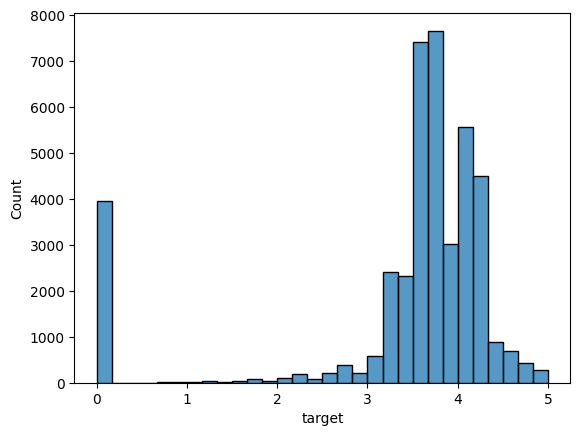

In [53]:
import seaborn as sns


sns.histplot(train.target, bins=30)

<Axes: xlabel='target', ylabel='Count'>

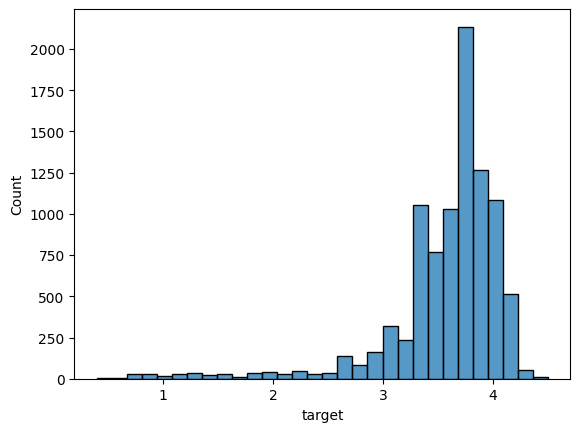

In [55]:
sns.histplot(test.target, bins=30)